# PyGLImER Tutorial

In this Python notebook we'll describe the first steps to be taken with PyGLImER.
The python API for creating, processing, and imaging a receiver function database.

The main code is hosted here: [PyGLImER](https://github.com/PeterMakus/PyGLImER).

The documentation, which this notebook is based upon is located here:
[PyGLImER Documentation](https://petermakus.github.io/PyGLImER/).

Without further ado, we'll dive right into it starting with data download.

---

## Intro and database setup

In this Tutorial we are going to get all good receiver functions 
for the year 2018 for station IU-HRV ([Adam Dziewonski Observatory](http://www.seismology.harvard.edu/hrv.html)).

To Compute the receiver function we need to download and organize
the observed data.
To take glimpse of how we are structuring the downloaded data,
expand the database tree below.


<details>
<summary> Database tree: </summary>

```
database
|____events
| |____2020-07-04 14:52:05.137534
| |____ ...
| |____2020-07-04 14:11:16.669280
|
|____stations
| |____IU.HRV.xml
|
|____preprocessed
| |____P
|   |____by_event
|   | |____2018172T160800_-24.5_-67.0
|   | | |____IU.HRV.2018172T160800.mseed
|   | |____ ...
|   | |____2018014T091850_-16.0_-74.5
|   | | |____IU.HRV.2018014T091850.mseed
|   | |____2018283T231600_49.5_156.5
|   | | |____IU.HRV.2018283T231600.mseed
|   | |____ ...
|   | |____2018339T064300_-22.0_169.5
|   | |____2018023T230910_-6.0_-12.5        # Seems to keep the empty dirs...
|   |____by_station
|     |____IU
|       |____HRV
|         |____info.db
|         |____IU.HRV.2018021T010640.mseed
|         |____ ...
|         |____IU.HRV.2018236T090410.mseed
|
|____waveforms
| |____P
|   |____2018100T101930_-31.0_-71.5
|   | |____IU.HRV.mseed
|   |____ ...
|   |____2018023T230910_-6.0_-12.5
|     |____IU.HRV.mseed
|
|____RF
| |____P
|   |____IU
|     |____HRV
|       |____IU.HRV.2018224T211500.sac
|       |____ ...
|       |____IU.HRV.2018250T021210.sac
|____RF.log
|____download.log
|____preprocess.log
```
</details>



While it might look a bit intimidating, the structure is fairly simple.
There are 5 main directories: 

1. `events`, containing event data in form of a `QuakeML` catalog.
2. `stations`, containing all station Metadata in form of `StationXML`s.
3. `waveforms`, containing waveform sorted after
    1. Converted phase (`P` or `S`)
    2. Event
    3. `NET.STA.mseed`
4. `preprocessed`, containing cleaned-up RTZ traces. Sorted
    after
    1. Converted phase (`P` or `S`)
    2. `by_event` ...
        1. Event timestamp and location
        2. `NET.STA.mseed`
    2. ... or `by_station`      
        1. Network
        2. Station
        3. `NET.STA.<EVENT_UTC_STAMP>.mseed`
5. `RF`, containing the final Receiver functions.
    1. Converted phase (`P` or `S`)
    2. `NETWORK`
    3. `STATION`
    4. `NET.STA.<EVENT_UTC_STAMP>.sac`
    


***The `by_event` folder does only contain softlinks to the files in `by_station`.***

## Downloading the raw data

To download the data we use the `pyglimer.waveform.request.Request` class.
The first method from this class that we are going to use is the 
download event catalog public method `Request.download_evtcat()`,
to get a set of events that contains all wanted earthquakes.

To initialize said `class` we setup a parameter dictionary, with 
all the needed information. Let's look at the expected information:

In [1]:
%load_ext autoreload
%autoreload 2

import inspect
from pyglimer.waveform.request import Request

# Get expected input arguments
signature = inspect.signature(Request)
print(signature)

# Uncomment for long explanation
help(Request)

(phase: str, rot: str, evtloc: str, statloc: str, rawloc: str, preproloc: str, rfloc: str, deconmeth: str, starttime: obspy.core.utcdatetime.UTCDateTime, endtime: obspy.core.utcdatetime.UTCDateTime, pol: str = 'v', minmag: float = 5.5, event_coords: tuple = None, network: str = None, station: str = None, waveform_client: list = None, re_client=['IRIS'], evtcat: obspy.core.event.catalog.Catalog = None, loglvl: int = 30)
Help on class Request in module pyglimer.waveform.request:

class Request(builtins.object)
 |  Request(phase: str, rot: str, evtloc: str, statloc: str, rawloc: str, preproloc: str, rfloc: str, deconmeth: str, starttime: obspy.core.utcdatetime.UTCDateTime, endtime: obspy.core.utcdatetime.UTCDateTime, pol: str = 'v', minmag: float = 5.5, event_coords: tuple = None, network: str = None, station: str = None, waveform_client: list = None, re_client=['IRIS'], evtcat: obspy.core.event.catalog.Catalog = None, loglvl: int = 30)
 |  
 |  "Initialises the FDSN request for
 |  the w

So, let's setup a dictionary to handle the input:

In [2]:
import os
from obspy import UTCDateTime

# Get notebook path for future reference of the database:
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# Define file locations

request_dict = {
    # Necessary arguments
    'proj_dir': proj_dir,
    'raw_subdir': 'waveforms/raw', # Directory of the waveforms
    'prepro_subdir': 'waveforms/preprocessed',  # Directory of the preprocessed waveforms
    'rf_subdir': 'waveforms/RF',  # Directory of the receiver functions
    'statloc_subdir': 'stations', # Directory stations
    'evt_subdir': 'events',     # Directory of the events
    'log_subdir': 'log',        # Directory for the logs
    'loglvl': 'WARNING',        # logging level
    'format': 'mseed',          # Format to save database in
    "phase": "P",               # 'P' or 'S' receiver functions
    "rot": "RTZ",               # Coordinate system to rotate to
    "deconmeth": "waterlevel",  # Deconvolution method
    "starttime": UTCDateTime(2019, 1, 1, 0, 0, 0), # Starttime of database. In this case, starttime of HRV
    "endtime": UTCDateTime.now(),   # Endtimetime of database
    # kwargs below
    "pol": 'v',                  # Source wavelet polaristion. Def. "v" --> SV
    "minmag": 5.5,               # Earthquake minimum magnitude. Def. 5.5
    "event_coords": None,        # Specific event?. Def. None
    "network": "IU",             # Restricts networks. Def. None
    "station": "HRV",            # Restricts stations. Def. None
    "waveform_client": ["IRIS"], # FDSN server client (s. obspy). Def. None
    "re_client": ['IRIS'],       # irrelevant for normal use
    "evtcat": None
}

---
**NOTE to Peter:**
This could be loaded as a configuration file via a `yaml` reader. I have one that takes into account UTCdatetimes, so that it loads UTCDatetime correctly (I think..., might be json as well, doesn't really matter, I'll show you what I mean)

---

Now that we have all parameters in place, let's initialize the `Request` `class`

In [3]:
R = Request(**request_dict)

2021-07-05 12:28:13,944 - INFO - Long request: Breaking it down to 3 sub-requests.
100%|██████████| 3/3 [00:33<00:00, 11.23s/it]
2021-07-05 12:28:47,755 - INFO - Successfully obtained 1137 events


To check whether the data download was successful, 
let's plot the events in the catalog on a map:

In [4]:
from pyglimer.plot.plot_utils import set_mpl_params
from pyglimer.plot.plot_utils import plot_catalog
set_mpl_params()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


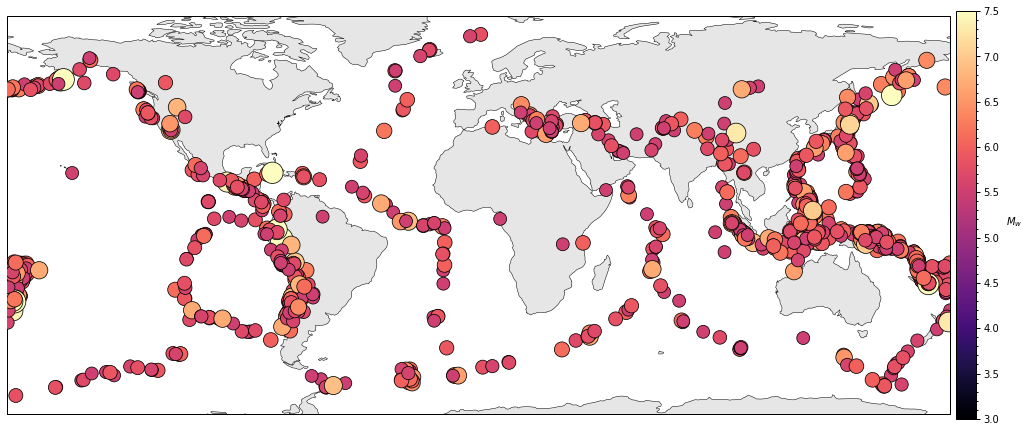

In [5]:
plot_catalog(R.evtcat) 

Number of events:

In [6]:
print(len(R.evtcat))

1137


## Get waveform data

The next step on our journey to receiver functions is retrieving
the corresponding waveform data.
To retrieve the waveform data, we use the `Request`'s
public method, `download_waveforms()`. 
This method uses the station and event locations to get viable
records of receiver function depending on epicentral distance and
traveltimes.

---
***NOTE:*** This might take a while.

---

In [7]:
R.download_waveforms()

[2021-07-05 12:28:48,498] - obspy.clients.fdsn.mass_downloader - INFO: Initializing FDSN client(s) for IRIS.
[2021-07-05 12:28:48,500] - obspy.clients.fdsn.mass_downloader - INFO: Successfully initialized 1 client(s): IRIS.
  0%|          | 0/1137 [00:00<?, ?it/s][2021-07-05 12:28:48,501] - obspy.clients.fdsn.mass_downloader - INFO: Downloading event: 2019364T171857.6730Z
[2021-07-05 12:28:48,502] - obspy.clients.fdsn.mass_downloader - INFO: Total acquired or preexisting stations: 0
[2021-07-05 12:28:48,502] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - Requesting reliable availability.
[2021-07-05 12:28:48,930] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - No data available for request.
[2021-07-05 12:28:48,932] - obspy.clients.fdsn.mass_downloader - INFO: Client 'IRIS' - No data available.
[2021-07-05 12:28:48,933] - obspy.clients.fdsn.mass_downloader - INFO: ============================== Final report
[2021-07-05 12:28:48,936] - obspy.clients.fdsn.mass_

[('IU', 'HRV', '*', '*', '*', '*')]


Should the download be successful, we can check the number of waveforms downloaded with a bash oneliner

In [8]:
print("Number of downloaded waveforms:")
!ls database/waveforms/raw/P/**/*.mseed | wc -l

Number of downloaded waveforms:
1704


This means that we can get 

## Preprocessing

Now, that we have all the waveform data in place.
We can perform the first preprocessing. This part includes:

1. Clips waveform to the right length
   (tz before and ta after theorethical arrival.)
2. Demean & Detrend
3. Tapering
4. Remove Instrument response, convert to velocity &
   simulate havard station
5. Rotation to NEZ and, subsequently, to RTZ.
6. Compute SNR for highpass filtered waveforms
   (highpass f defined in qc.lowco)
   If SNR lower than in qc.SNR_criteria for all filters,
   rejects waveform.
7. Write finished and filtered waveforms to folder
   specified in qc.outputloc.
8. Write info file with shelf containing station,
   event and waveform information.
9. (Optional) If we had chosen a different coordinate system in ``rot``
   than RTZ, it would now cast the preprocessed waveforms information
   that very coordinate system.
10. Deconvolution with method ``deconmeth`` from our dict is perfomed.
   
It again uses the request class to perform this.


In [9]:
import obspy
C = obspy.clients.fdsn.Client()

In [10]:
# Redownload inventory
inv = C.get_stations(network="IU", station="HRV", starttime=UTCDateTime(1980,1,1), endtime=UTCDateTime.now(), level="response")
inv.write("database/stations/IU.HRV.xml", format="STATIONXML")


R.preprocess(hc_filt=1.5)

2021-07-05 13:08:18,067 - INFO - 


...Preprocessing initialiased...

2021-07-05 13:08:18,489 - INFO - Before cut and resample
2021-07-05 13:08:18,489 - INFO -    Time elapsed: 0.4 s
2021-07-05 13:08:18,503 - INFO - Unprocessed file rewritten
2021-07-05 13:08:18,504 - INFO -    Time elapsed: 0.0 s
2021-07-05 13:08:18,530 - DEBUG - ['IU.HRV.mseed', 'QC was not met, SNR ratios are', SNRError('[[  2.10902293   1.07644656   2.45294915]\n [  1.65278955   1.45106692   2.78700026]\n [  1.456762     1.4858508   12.9282228 ]]')]
2021-07-05 13:08:18,531 - INFO - File preprocessed.
2021-07-05 13:08:18,531 - INFO -    Time elapsed: 0.5 s
2021-07-05 13:08:18,985 - INFO - Before cut and resample
2021-07-05 13:08:18,986 - INFO -    Time elapsed: 0.4 s
2021-07-05 13:08:18,994 - INFO - Unprocessed file rewritten
2021-07-05 13:08:18,995 - INFO -    Time elapsed: 0.0 s
2021-07-05 13:08:19,012 - DEBUG - ['IU.HRV.mseed', 'QC was not met, SNR ratios are', SNRError('[[ 4.08899015  0.6614491   2.95463835]\n [

Download and preprocessing finished.


# First RF Plots

The following few section show how to plot 

1. Single raw RFs
2. A set of raw RFs
3. A move-out corrected RF
4. A set of move-out corrected RFs


## Read the IU-HRV receiver functions as a Receiver function stream

Let's read a receiver function set and see what it's all about! 
(i.e. let's look at what data a Receiver function trace contains
and how we can use it!)

In [11]:
from pyglimer.rf.create import read_rf
from utils.plot_utils import plot_single_rf, set_mpl_params
set_mpl_params()

rfst = read_rf("database/waveforms/RF/P/IU/HRV/*.sac")
print("Number of RFs: ", len(rfst))
print()
print(rfst[0].stats)

Number of RFs:  63

          network: IU
          station: HRV
         location: 00
          channel: PRF
        starttime: 2019-01-05T19:33:14.269538Z
          endtime: 2019-01-05T19:35:44.269538Z
    sampling_rate: 10.0
            delta: 0.1
             npts: 1501
            calib: 1.0
          _format: SAC
     back_azimuth: 180.032
         distance: 50.4427
      event_depth: 571180.0
   event_latitude: -8.1486
  event_longitude: -71.5834
  event_magnitude: 6.8
       event_time: 2019-01-05T19:25:38.580005Z
            onset: 2019-01-05T19:33:44.232505Z
            phase: P
              sac: AttribDict({'delta': 0.1, 'depmin': -0.38808015, 'depmax': 1.0185748, 'scale': 1.0, 'b': 0.00053800002, 'e': 150.00053, 'o': -455.689, 'a': 29.963505, 'stla': 42.506401, 'stlo': -71.558296, 'stel': 200.0, 'evla': -8.1485996, 'evlo': -71.583397, 'evdp': 571180.0, 'mag': 6.8000002, 'user1': 7.2773123, 'baz': 180.03227, 'gcarc': 50.442715, 'depmen': -0.00020591504, 'nzyear': 2019, 'nzj

## Plot the raw RFs

If the Receiver functions haven't been further processed,
they are plotted as a function of time. A single receiver
function in the stream will be plotted as function of time
only. A full stream can make use of the distance measure saved
in the sac-header and plot an entire section as a function of
time and epicentral distance.

### Plot single RF

Below we show hoe to plot the receiver function
as a function of time, and the clean option, which plots
the receiver function without any axes or text.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


ValueError: Format 'none' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

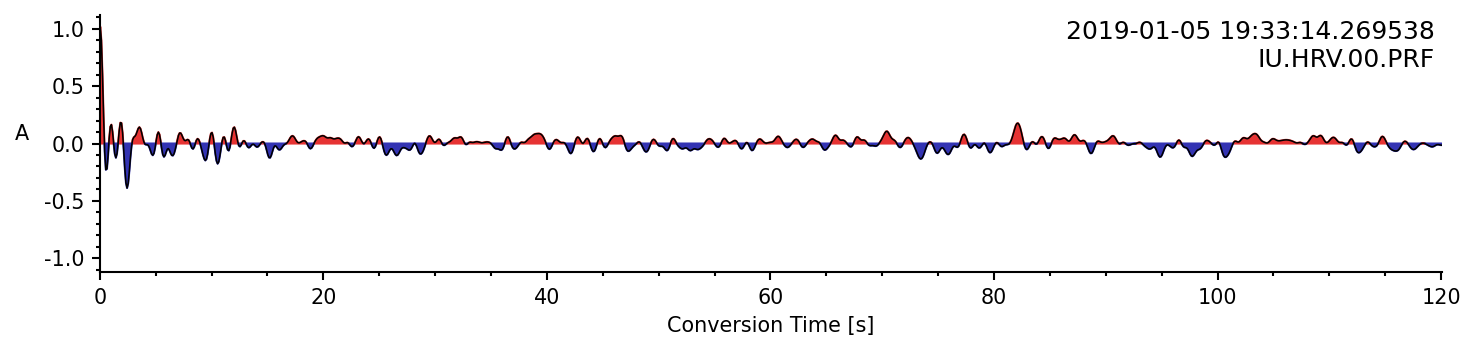

In [12]:
from pyglimer.plot.plot_utils import set_mpl_params
from pyglimer.plot.plot_utils import plot_single_rf

# Plot RF and save its output.
rfst[0].plot(outputdir="./")

<AxesSubplot:xlabel='Conversion Time [s]', ylabel='A    '>

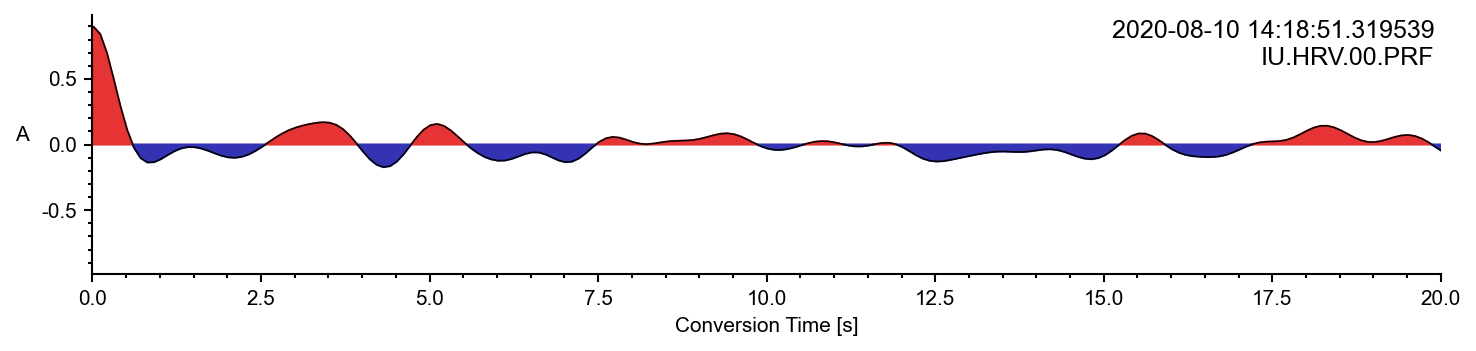

In [ ]:
rfst[0].plot(tlim=[0,20])

<AxesSubplot:>

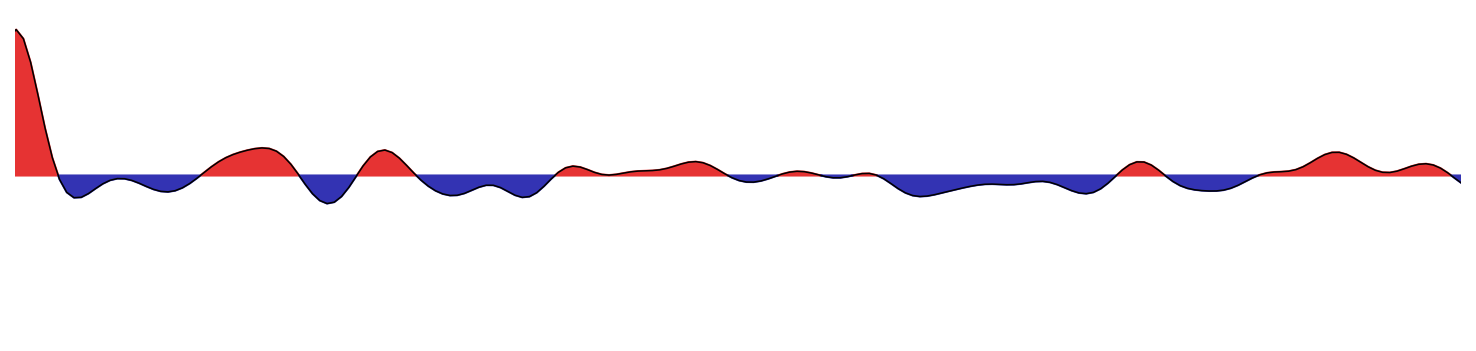

In [ ]:
rfst[0].plot(clean=True, tlim=[0,20])

### Plot a receiver function section

Here, we show how to plot the receiver functions as raw data in sections,
and how we can quickly modify the code to just look at the RF's you are
interested in.

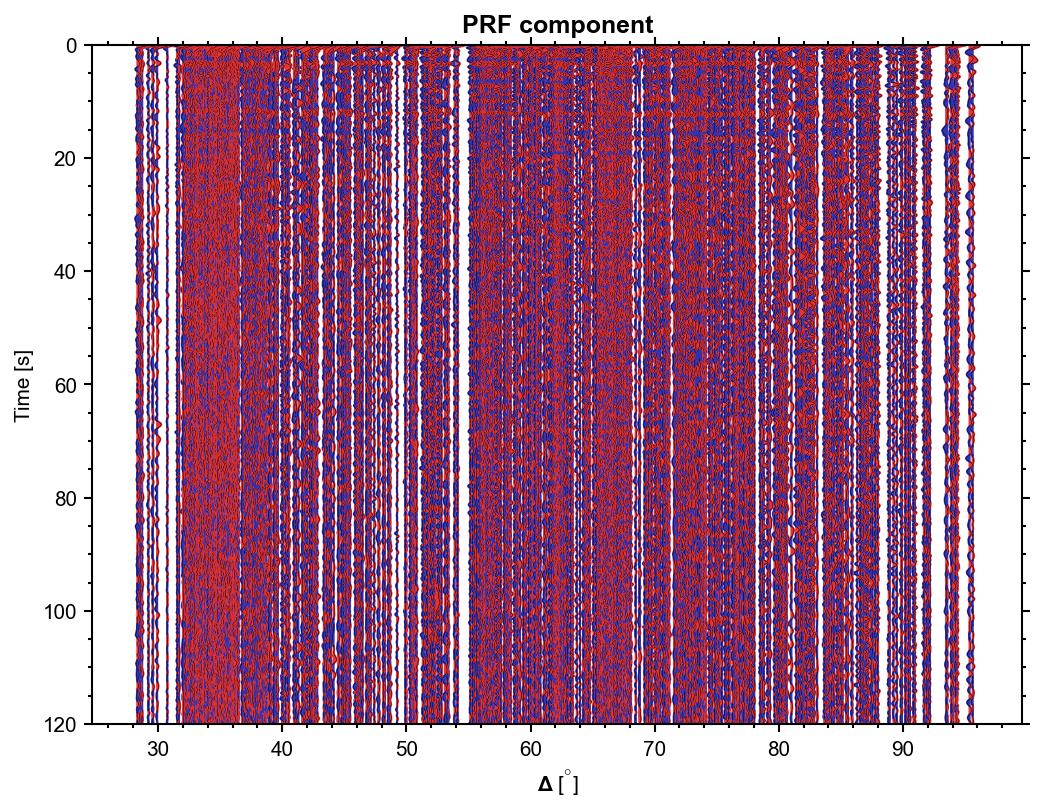

<AxesSubplot:title={'center':'PRF component'}, xlabel='$\\Delta$ [$^{\\circ}$]', ylabel='Time [s]'>

In [ ]:
from pyglimer.rf.create import read_rf
from pyglimer.plot.plot_utils import plot_section
set_mpl_params()

rfst = read_rf("database/waveforms/RF/P/IU/HRV/*.sac")

rfst.plot(scalingfactor=1)

We can also parse arguments to the function that sets were in the section we want to look and
how the section looks.

<AxesSubplot:title={'center':'PRF component'}, xlabel='$\\Delta$ [$^{\\circ}$]', ylabel='Time [s]'>

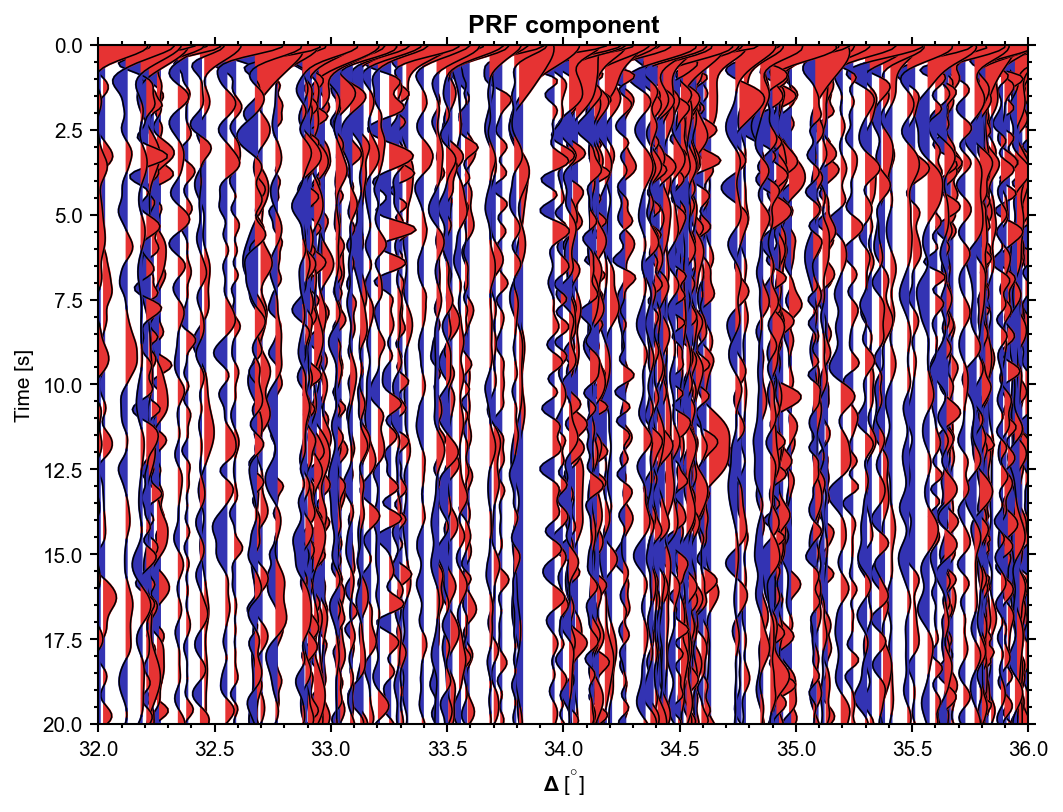

In [ ]:
# We can parse limits to the function
timelimits = (0, 20)  # seconds  
epilimits = (32, 36)  # epicentral distance
rfst.plot(
    scalingfactor=0.25, timelimits=timelimits, epilimits=epilimits,
    linewidth=0.75, outputfile="./stack_limit.png")

By increasing the scaling factor and removing the plotted lines, we can
already see trends:

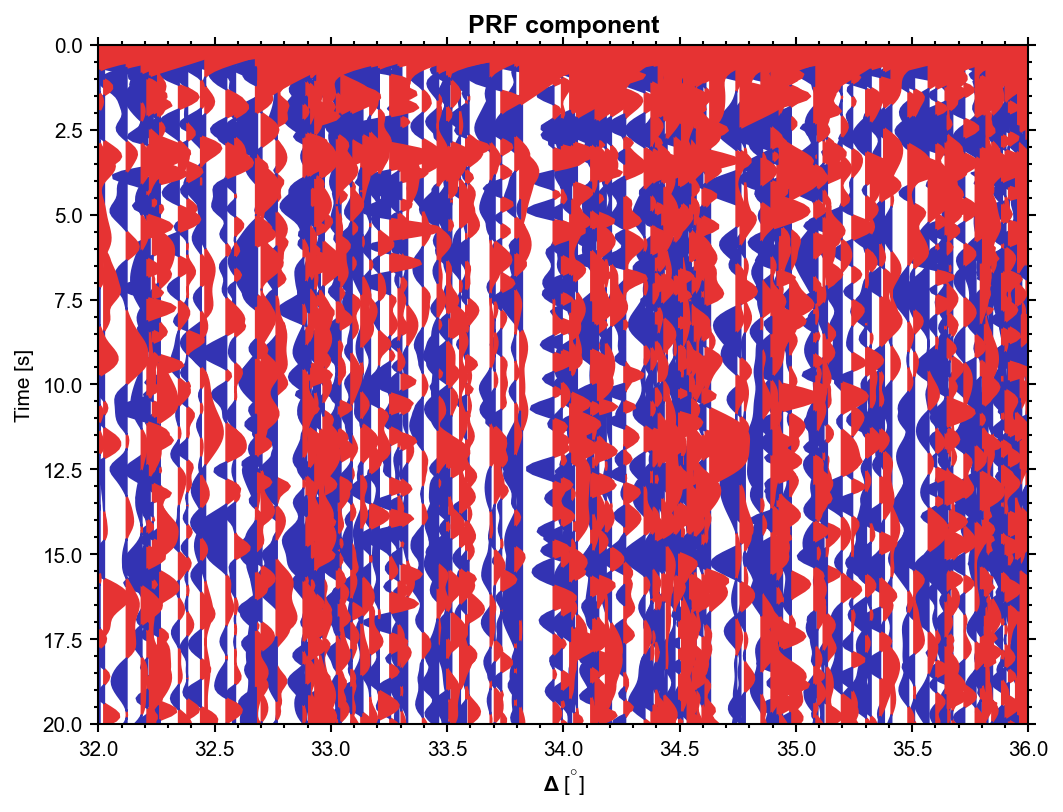

<AxesSubplot:title={'center':'PRF component'}, xlabel='$\\Delta$ [$^{\\circ}$]', ylabel='Time [s]'>

In [ ]:
rfst.plot(
    scalingfactor=0.5, timelimits=timelimits, epilimits=epilimits, 
    line=False)

See, e.g., around 11.0 and 16.0 seconds.